In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cookie-cats/cookie_cats.csv


  This notebook analyzes an A/B test in the mobile game **Cookie Cats**. As players go through the game, some parts get locked, and they have to either **wait or pay** to continue. These **gates** normally appear at **level 30**, but developers tested if delaying the first gate to **level 40** would keep players more engaged.  

The dataset tracks how players behave with the gate at **level 30 and level 40**. The goal is to see if changing the gate position affects **how long players stay in the game** and how many game rounds they play.

## Exploratory Data Analysis

In [27]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

In [28]:
df = pd.read_csv('../input/cookie-cats/cookie_cats.csv')
df.describe()

,userid,sum_gamerounds
count,90189.0000,90189.0000
mean,4998412.2345,51.8725
std,2883285.6077,195.0509
min,116.0000,0.0000
25%,2512230.0000,5.0000
50%,4995815.0000,16.0000
75%,7496452.0000,51.0000
max,9999861.0000,49854.0000


The maximum value is significantly higher than Q3, and more than three times the standard deviation, suggesting that there are potential outliers in the data among higher values.

In [29]:
df[['version', 'retention_1', 'retention_7']].describe()

,version,retention_1,retention_7
count,90189,90189,90189
unique,2,2,2
top,gate_40,False,False
freq,45489,50036,73408


In [30]:
df['userid'].duplicated().sum()

0

In [31]:
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

This dataset contains 90,189 unique users. Based on this quick data analysis, it seems there are no null or duplicated values.

There are 5 attributes in the dataset:

1. **`userid`** (integer): A unique identifier for each user.
2. **`version`** (object): Contains two values, `gate_30` and `gate_40`, representing different tests (A and B).
3. **`sum_gamerounds`** (integer): The number of rounds played by the player during the first week after installation.
4. **`retention_1`** (boolean): Indicates whether the player returned to play 1 day after installing.
5. **`retention_7`** (boolean): Indicates whether the player returned to play 7 days after installing.

*Both ******`retention_1`****** and ******`retention_7`****** can be either ******`False`****** or ******`True`****** at the same time.*


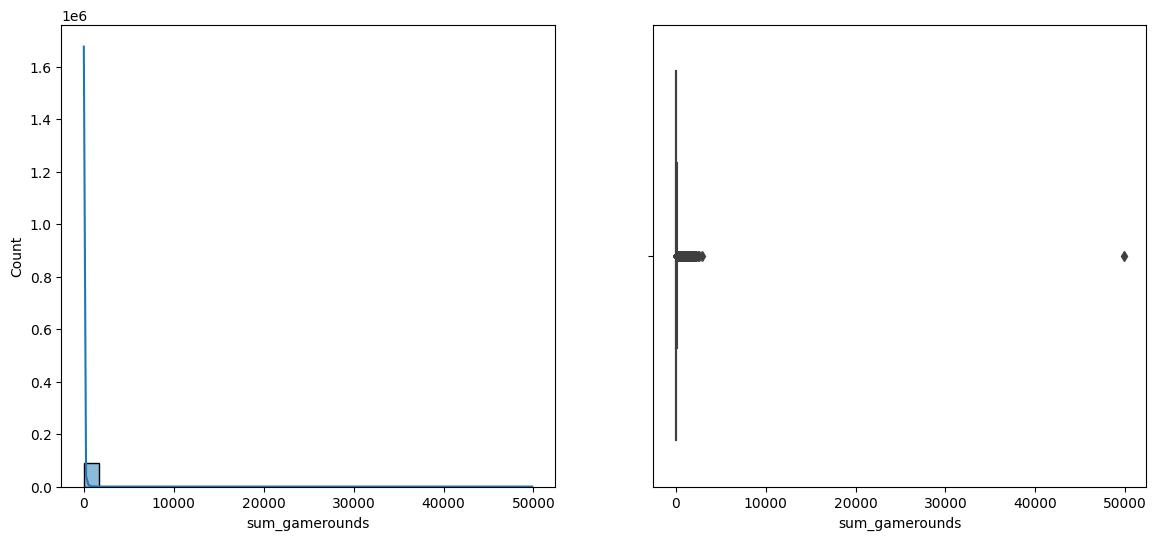

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df['sum_gamerounds'], kde=True, bins=30, ax=axes[0])
sns.boxplot(x=df['sum_gamerounds'], ax=axes[1])
plt.show()

In [33]:
import scipy.stats as stats

stat, p_value = stats.shapiro(df['sum_gamerounds'])
print(stat, p_value)
if p_value < 0.05:
    print('Not normal distribution')
else:
    print('Normal distribution')

0.14405474382512773 4.662157693891366e-176
Not normal distribution


Considering non-normality, in the following lines different strategies for outliers removal is explored and proceeded with the best approach.

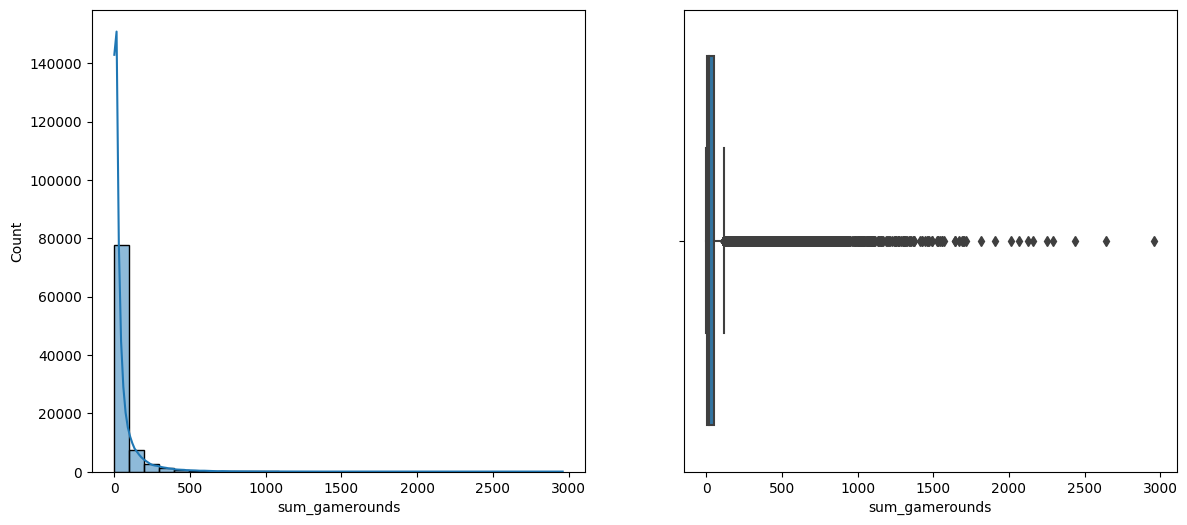

In [34]:
# removing max value
df1 = df[df.sum_gamerounds < df.sum_gamerounds.max()]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df1['sum_gamerounds'], kde=True, bins=30, ax=axes[0])
sns.boxplot(x=df1['sum_gamerounds'], ax=axes[1])
plt.show()

In [35]:
# removing q1 and q4
upper_range = df['sum_gamerounds'].quantile(0.75) + 1.5*(df['sum_gamerounds'].quantile(0.75) - df['sum_gamerounds'].quantile(0.25))
lower_range = df['sum_gamerounds'].quantile(0.25) - 1.5*(df['sum_gamerounds'].quantile(0.75) - df['sum_gamerounds'].quantile(0.25))

print(f"If quantile removal is performed {100-100*df[(df['sum_gamerounds']>lower_range) & (df['sum_gamerounds']<upper_range)].shape[0]/df.shape[0]} % of data will be lost")


If quantile removal is performed 11.393850691325994 % of data will be lost


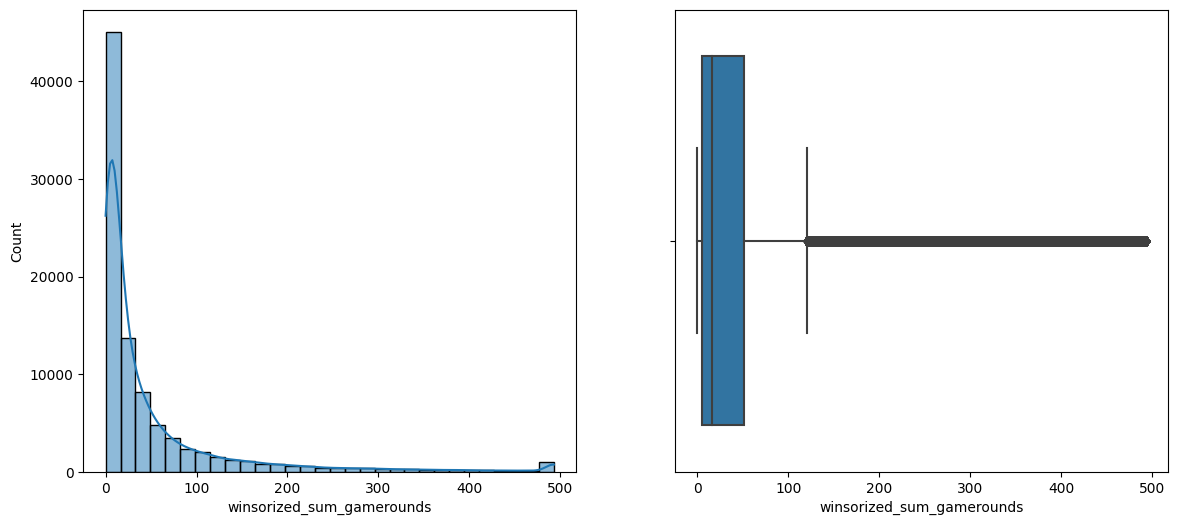

In [36]:
# Winsorization
lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)
df['winsorized_sum_gamerounds'] = df['sum_gamerounds'].clip(lower=lower_limit, upper=upper_limit)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plots
sns.histplot(df['winsorized_sum_gamerounds'], kde=True, bins=30, ax=axes[0])
sns.boxplot(x=df['winsorized_sum_gamerounds'], ax=axes[1])
plt.show()


This method unnaturaly distributes data to both ends.

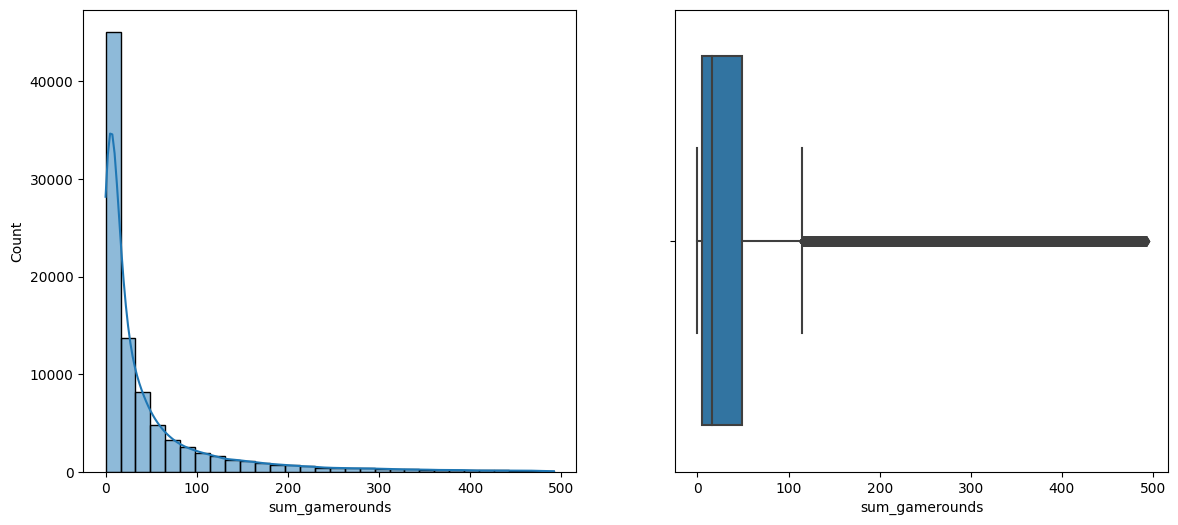

In [37]:
#lower_limit = df['sum_gamerounds'].quantile(0.01)
upper_limit = df['sum_gamerounds'].quantile(0.99)

df = df[(df['sum_gamerounds']<upper_limit)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plots
sns.histplot(df['sum_gamerounds'], kde=True, bins=30, ax=axes[0])
sns.boxplot(x=df['sum_gamerounds'], ax=axes[1])
plt.show()

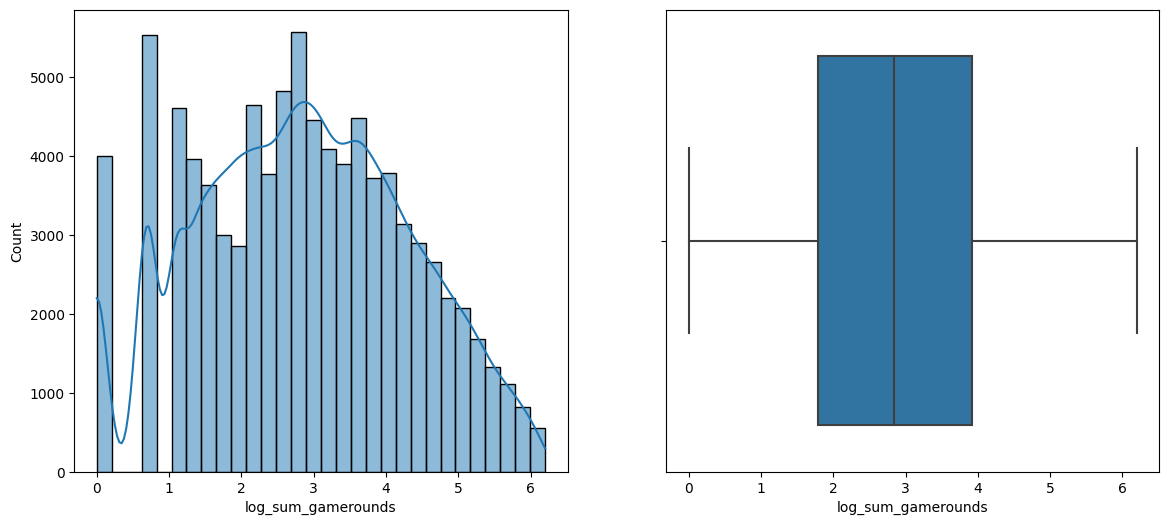

In [38]:
df['log_sum_gamerounds'] = np.log(df['sum_gamerounds'] + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df['log_sum_gamerounds'], kde=True, bins=30, ax=axes[0])
sns.boxplot(x=df['log_sum_gamerounds'], ax=axes[1])
plt.show()

In [39]:
stat, p_value = stats.shapiro(df['log_sum_gamerounds'])
print(stat, p_value)
if p_value < 0.05:
    print('Not normal distribution')
else:
    print('Normal distribution')

0.9851632160956365 2.4888932200323644e-64
Not normal distribution


Since log transformation does not make a normal distribution which was the option considering skewness the best outlier removal approach is deleting upper 1 percentile of data which is jus 1% loss.

In [40]:
df = df.drop(columns=['log_sum_gamerounds', 'winsorized_sum_gamerounds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89283 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          89283 non-null  int64 
 1   version         89283 non-null  object
 2   sum_gamerounds  89283 non-null  int64 
 3   retention_1     89283 non-null  bool  
 4   retention_7     89283 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.9+ MB


Given the non-normality, parametric tests like the t-test and ANOVA are not appropriate for A/B testing. I will conduct further analysis and derive insights before selecting the most suitable statistical approach for A/B testing.

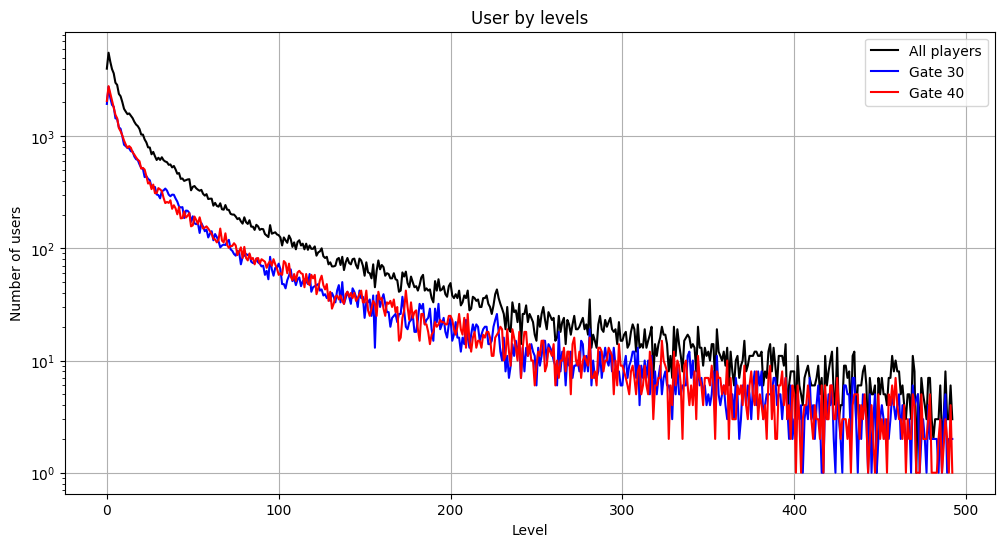

In [41]:
group_a = df[df['version']=='gate_30']
group_b = df[df['version']=='gate_40']
# group by level and count users
all_players = df.groupby('sum_gamerounds')['userid'].count()
gate_30 = group_a.groupby('sum_gamerounds')['userid'].count()
gate_40 = group_b.groupby('sum_gamerounds')['userid'].count()

# plot all three on the same graph
plt.figure(figsize=(12, 6))

plt.plot(all_players.index, all_players.values, color='black', label='All players')
plt.plot(gate_30.index, gate_30.values, color='blue', label='Gate 30')
plt.plot(gate_40.index, gate_40.values, color='red', label='Gate 40')

plt.xlabel('Level')
plt.ylabel('Number of users')
plt.title('User by levels')
plt.yscale('log')  # log scale for better visibility
plt.legend()
plt.grid()
plt.show()


In [42]:
df.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44249.0000,44.6118,71.9670,0.0000,5.0000,16.0000,48.0000,492.0000
gate_40,45034.0000,44.3665,71.4483,0.0000,5.0000,16.0000,50.0000,492.0000


In [43]:
print(df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]))
print(df.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]))

                     count  median    mean     std  max
version retention_1                                    
gate_30 False        24653  6.0000 15.9924 32.2851  483
        True         19596 46.0000 80.6169 89.7616  492
gate_40 False        25360  6.0000 16.0471 32.3710  489
        True         19674 48.0000 80.8705 89.2650  492
                     count   median     mean      std  max
version retention_7                                       
gate_30 False        36176  11.0000  25.4185  40.3883  490
        True          8073  97.0000 130.6191 109.6878  492
gate_40 False        37192  11.0000  25.5185  40.2697  491
        True          7842 104.0000 133.7564 109.3172  492


The dataset presented several challenges, particularly in handling outliers and addressing its non-normal distribution. Various techniques, including Winsorization and log transformation, were explored, but normality could not be achieved.

Exploratory Data Analysis (EDA) revealed that placing the gate at level 30 or 40 does not appear to create a significant difference in user behavior at first glance. However, a rigorous A/B test is still necessary to validate this observation statistically.

Since the data is not normally distributed, parametric tests like the t-test or ANOVA are not suitable. Instead, a non-parametric approach such as the Mann-Whitney U test will be considered for comparing user engagement metrics between the two groups. Additionally, retention rates will be analyzed using a Chi-square test to determine if there is a significant difference in user retention between the two versions.

With these considerations, the next step is to proceed with proper A/B testing and statistical validation to determine whether the gate placement has a meaningful impact on user behavior.

## Frequentist A/B testing

In this section, hypothesis testing is performed to evaluate whether there is a statistically significant reason to prefer the new feature. Given the amount of available data, the following hypotheses were tested:

### 1. Impact of Feature Change on sum_gamerounds
Since the distribution of sum_gamerounds is non-normal, the Mann-Whitney U test is used to assess statistical significance. To measure the effect size, Cliff's Delta is calculated.
 - H0: There is no statistically significant difference in the number of game rounds between players in gate level 30 and gate level 40.
 - H1: There is a statistically significant difference in the number of game rounds between players in gate level 30 and gate level 40.

Why Mann-Whitney U? - It's a non-parametric test suitable for comparing two independent groups when the data is not normally distributed.

Why Cliff's Delta? - It quantifies the amount of overlap between two groups and helps understand the magnitude of the effect.

### 2. Impact of Gate Change on Retention (Day 1 and Day 7)
For retention variables (retention_1, retention_7), which are binary (True/False), and with categorical versions (gate_30, gate_40), a Chi-Square Test of Independence is used. To assess effect size, Cramer’s V is computed.
 - H0: Gate change does not affect user retention.
 - H1: Gate change affects user retention.

Why Chi-Square? - Appropriate for categorical variables to test whether distributions of sample categorical variables differ from each other.

Why Cramér’s V? - Measures the strength of association between two nominal variables.



In [44]:
def cliffs_delta(x, y):

    from itertools import product

    more = sum(1 for xi, yi in product(x, y) if xi > yi)
    less = sum(1 for xi, yi in product(x, y) if xi < yi)

    delta = (more - less) / (len(x) * len(y))

    # Interpretation
    abs_delta = abs(delta)
    if abs_delta < 0.147:
        interpretation = "negligible"
    elif abs_delta < 0.33:
        interpretation = "small"
    elif abs_delta < 0.474:
        interpretation = "medium"
    else:
        interpretation = "large"

    return delta, interpretation

In [45]:
A1 = group_a['sum_gamerounds']
B1 = group_b['sum_gamerounds']
stat, p_value = stats.mannwhitneyu(A1, B1, alternative='two-sided')
print(stat, p_value)
if p_value < 0.05:
    print('statictically SIGNIFICANT for game rounds')
else:
    print('statictically UNSIGNIFICANT for game rounds')

delta, size = cliffs_delta(A1, B1)
print(f"Cliff's Delta: {delta}, Effect Size: {size}")

1003924146.0 0.04922893919690299
statictically SIGNIFICANT for game rounds
Cliff's Delta: 0.00759710648155269, Effect Size: negligible


In [46]:
from scipy.stats import chi2_contingency

def cramers_v(contingency_table):
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.to_numpy().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(r - 1, k - 1))

def interpret_cramers_v(v):
    if v < 0.1:
        return "negligible"
    elif v < 0.3:
        return "small"
    elif v < 0.5:
        return "medium"
    else:
        return "large"

In [47]:
# retention_1
contingency_1 = pd.crosstab(df['version'], df['retention_1'])
stat1, p1, dof1, expected1 = chi2_contingency(contingency_1)
cramers_v_1 = cramers_v(contingency_1)
effect_size_1 = interpret_cramers_v(cramers_v_1)

print("Chi-Square Test for retention_1")
print(f"Chi-Square Statistic: {stat1:.4f}, p-value: {p1:.4f}, Degrees of Freedom: {dof1}")
print(f"Expected frequencies:\n{expected1}")
print("Statistically " + ("SIGNIFICANT" if p1 < 0.05 else "UNSIGNIFICANT") + " for retention_1")
print(f"Cramér’s V for retention_1: {cramers_v_1:.4f} ({effect_size_1})")

print("\n" + "-"*50 + "\n")

# retention_7
contingency_2 = pd.crosstab(df['version'], df['retention_7'])
stat2, p2, dof2, expected2 = chi2_contingency(contingency_2)
cramers_v_7 = cramers_v(contingency_2)
effect_size_7 = interpret_cramers_v(cramers_v_7)

print("Chi-Square Test for retention_7")
print(f"Chi-Square Statistic: {stat2:.4f}, p-value: {p2:.4f}, Degrees of Freedom: {dof2}")
print(f"Expected frequencies:\n{expected2}")
print("Statistically " + ("SIGNIFICANT" if p2 < 0.05 else "UNSIGNIFICANT") + " for retention_7")
print(f"Cramér’s V for retention_7: {cramers_v_7:.4f} ({effect_size_7})")

Chi-Square Test for retention_1
Chi-Square Statistic: 3.2234, p-value: 0.0726, Degrees of Freedom: 1
Expected frequencies:
[[24786.63616814 19462.36383186]
 [25226.36383186 19807.63616814]]
Statistically UNSIGNIFICANT for retention_1
Cramér’s V for retention_1: 0.0060 (negligible)

--------------------------------------------------

Chi-Square Test for retention_7
Chi-Square Statistic: 10.4647, p-value: 0.0012, Degrees of Freedom: 1
Expected frequencies:
[[36361.46446692  7887.53553308]
 [37006.53553308  8027.46446692]]
Statistically SIGNIFICANT for retention_7
Cramér’s V for retention_7: 0.0108 (negligible)




### 1. Game Rounds:
- Mann-Whitney U Test revealed a statistically significant difference between `gate_30` and `gate_40` versions in terms of game rounds.
- Cliff's Delta indicates that the effect size is very small, suggesting that the difference is not practically significant.

### 2. Retention at 1 Day:
- Chi-Square Test for `retention_1` showed a non-significant result.
- Cramer's V values for `retention_1` show low association.

### 3. Retention at 7 Days:
- Chi-Square Test for `retention_7` found a statistically significant result.
- Cramer's V for `retention_7` showed a weak association.

### Final Conclusion:
- While there is a statistical significance in retention at 7 days and game rounds, practical significance is weak


## Bayesian A/B testing

As an alternative to classical hypothesis testing, I also applied a Bayesian approach to compare 1-day and 7-day retention between groups.

This method estimates the probability that the new feature (Group B) is better than the control (Group A), based on observed data and prior beliefs. 

- Assumes a Beta prior (uninformative, alpha=1, beta=1)
- Posterior distributions are calculated using 100,000 samples
- The final result is the probability that retention in Group B > Group A

Bayesian P(B > A) for 1-day retention: 3.54%
Bayesian P(B > A) for 7-day retention: 0.05%


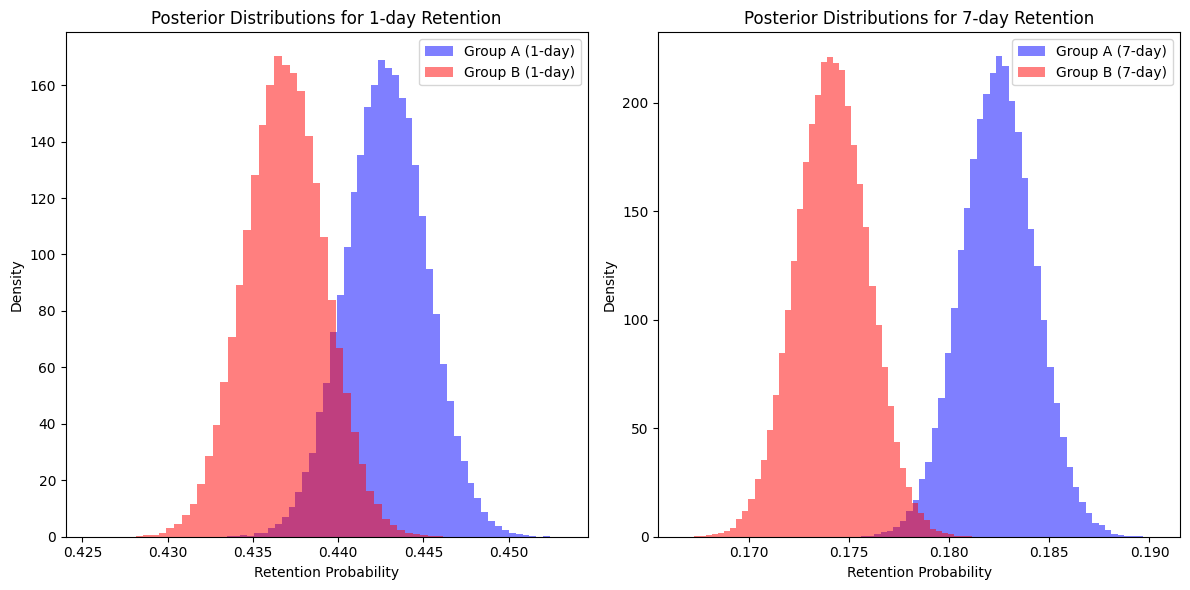

In [48]:
# Function to calculate the Bayesian probability that B is better than A
def bayesian_prob_b_better(a, b, samples=100000):
    alpha_a = a.sum() + 1  # successes + 1 (Beta prior)
    beta_a = len(a) - a.sum() + 1  # failures + 1 (Beta prior)
    alpha_b = b.sum() + 1  # successes + 1 (Beta prior)
    beta_b = len(b) - b.sum() + 1  # failures + 1 (Beta prior)

    # Draw samples from the posterior distributions
    samples_a = np.random.beta(alpha_a, beta_a, samples)
    samples_b = np.random.beta(alpha_b, beta_b, samples)

    # Calculate the probability that B is better than A
    return (samples_b > samples_a).mean(), samples_a, samples_b

prob_b_better_1, samples_a_1, samples_b_1 = bayesian_prob_b_better(group_a['retention_1'], group_b['retention_1'])
prob_b_better_7, samples_a_7, samples_b_7 = bayesian_prob_b_better(group_a['retention_7'], group_b['retention_7'])

print(f"Bayesian P(B > A) for 1-day retention: {prob_b_better_1:.2%}")
print(f"Bayesian P(B > A) for 7-day retention: {prob_b_better_7:.2%}")


plt.figure(figsize=(12, 6))

# plot 1-day retention
plt.subplot(1, 2, 1)
plt.hist(samples_a_1, bins=50, alpha=0.5, label='Group A (1-day)', density=True, color='blue')
plt.hist(samples_b_1, bins=50, alpha=0.5, label='Group B (1-day)', density=True, color='red')
plt.title('Posterior Distributions for 1-day Retention')
plt.xlabel('Retention Probability')
plt.ylabel('Density')
plt.legend()

# plot 7-day retention
plt.subplot(1, 2, 2)
plt.hist(samples_a_7, bins=50, alpha=0.5, label='Group A (7-day)', density=True, color='blue')
plt.hist(samples_b_7, bins=50, alpha=0.5, label='Group B (7-day)', density=True, color='red')
plt.title('Posterior Distributions for 7-day Retention')
plt.xlabel('Retention Probability')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()


### Bayesian Analysis Results

**1-Day Retention**  
  - Bayesian P(B > A): 3.66% - There is only a 3.66% probability that version gate_40 (Group B) has better 1-day retention than gate_30 (Group A). Group B is very unlikely to outperform Group A.

**7-Day Retention**  
  - Bayesian P(B > A): 0.06% - There is a 0.06% probability that Group B performs better than Group A in terms of 7-day retention — practically negligible.


## Conclusion

Both approaches strongly suggest that:
- **gate_40 does not improve retention**. In fact, it likely reduces both 1-day and 7-day retention compared to gate_30.
- Bayesian analysis strengthens the conclusion by explicitly quantifying the probability that B is better — which is very low.

### Recommendation

- **Do not proceed with gate_40**.
- Use gate_30 as the baseline going forward.
- Consider reworking or testing alternative variations for improving retention.
